AIM: To train ResNet50V2 model.

In [ ]:
# Note: Comment or delete the current code block if dataset is loaded from local disk.
# loading dataset from kaggle
# upload kaggle.json file
! pip install -q kaggle
from google.colab import files
print("Upload 'kaggle.json' file...")
files.upload()

# download the dataset(zipped folder) and unzip it
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download alessiocorrado99/animals10
! unzip animals10.zip

In [ ]:
# Note: Load the class files into current working directory.
# importing required libraries
from tensorflow.keras.utils import image_dataset_from_directory
import tensorflow as tf

from keras.callbacks import ModelCheckpoint

from imutils import paths
import matplotlib.pyplot as plt
import os

import resnet50v2 # class file
import helper_functions # class file

In [ ]:
# defining image size and batch size
batch_size=64
image_width=224
image_height=224

In [ ]:
# getting output class labels and calculating class weight
class_labels = sorted(os.listdir('raw-img')) # get class labels
print('\nClass Labels: {}'.format(class_labels))
num_classes = len(class_labels) # get number of output classes
print('\nNumber of Classes: {}'.format(num_classes))

# calculating total elements in each class
class_totals = [len(os.listdir('raw-img' + f"/{label}")) for label in class_labels]
print("\nTotal Elements in Each Class : {}".format(class_totals))

# calculate class weight
class_weight = {i:round((max(class_totals) / class_total), 3) for i, class_total in enumerate(class_totals)}
print('\nClass Weight: {}'.format(class_weight))


Class Labels: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']

Number of Classes: 10

Total Elements in Each Class : [4863, 2623, 1446, 2112, 3098, 1668, 1866, 1820, 4821, 1862]

Class Weight: {0: 1.0, 1: 1.854, 2: 3.363, 3: 2.303, 4: 1.57, 5: 2.915, 6: 2.606, 7: 2.672, 8: 1.009, 9: 2.612}


In [ ]:
# get image paths and move them into train and validation directories
imagePaths = list(paths.list_images("raw-img")) # getting path to the directory of images
print('Processing...')
helper_functions.move_images(imagePaths=imagePaths) # calling function
print('Completed...')

Processing...
Completed...


In [ ]:
# get training dataset
train_ds = image_dataset_from_directory(
  "train_dir/", label_mode='categorical', seed=42, shuffle=True,
  image_size=(image_height, image_width),
  batch_size=batch_size)

# get validation dataset
val_ds = image_dataset_from_directory(
  "valid_dir/", label_mode='categorical', seed=42, shuffle=True,
  image_size=(image_height, image_width),
  batch_size=batch_size)

Found 18325 files belonging to 10 classes.
Found 7854 files belonging to 10 classes.


In [ ]:
# using buffered prefetching
shuffle_size = len(train_ds) # shuffles entire train dataset at each epoch

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(shuffle_size).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

**Model:**

      INPUT => ResNet50V2 => GAP => DO => SOFTMAX

Observations:



1.   Trainable parameters: 20,490.
2.   Best epoch: 6.

  *   loss: 0.1240 - accuracy: 0.9780 - val_loss: 0.1517 - val_accuracy: 0.9593

3.   From epoch 7 onwards model starts overfitting quickly.

      

94668760/94668760 [==============================] - 3s 0us/step
Model Summary...
Model: "ResNet50V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                 

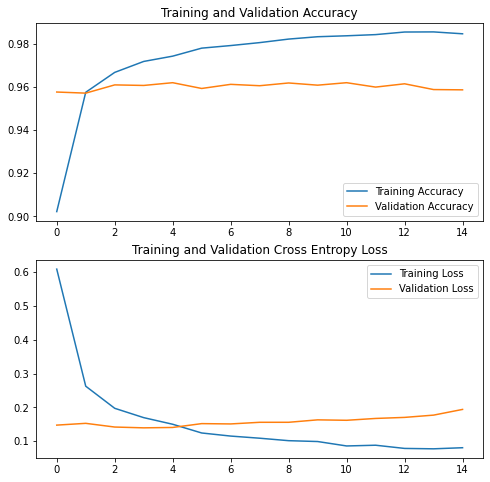

In [ ]:
# defining model architecture, subsequent training, and plotting graphs
# building the model
model = resnet50v2.ResNet50_V2.build(width=image_width, height=image_height, depth=3,
                                classes=num_classes, data_aug=False, dense_layer=False)

# compiling and summarizing the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
print('Model Summary...')
model.summary()

# defining callback - checkpoint
checkpoint = ModelCheckpoint('Models/ResNet50V2_Basic/resnet50v2_basic_{epoch:02d}_{val_loss:.3f}.h5', monitor='val_loss', 
                             mode='min', verbose=0, save_freq='epoch')
# total epochs
epochs = 15 

# training the model on defined parameters
print('\n\nModel Training...')
history = model.fit(
  train_ds, validation_data=val_ds, class_weight=class_weight, epochs=epochs, verbose=1,
  batch_size=batch_size, callbacks=[checkpoint] 
)

# plot accuracy and loss graphs of the trained model
print('\n\nModel Graphs...')
fig = helper_functions.plot_graphs(history=history)
plt.show()

**Conclusion:**



1.   Epoch 6 of ResNet50V2 model gives the best results. However, the results are not as good as given by best model from MobileNetV3Large. Also, the number of trainable parameters are 2X more than that of its counterpart.

2.   Size of ResNet50V2 is approximately 90 MB, which is approximately more than 8 times that of MobileNetV3Large (approximately 12 MB).
